In [2]:
# Cell 1 – Ümumi kitabxanalar və vizualizasiya
import pandas as pd
import numpy as np

# Train/Test split və qiymətləndirmə üçün ümumi ML kitabxanaları
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Model save/load
import joblib


In [3]:
# Cleaned və model üçün hazırlanmış datasetləri yükləyək
df_clean = pd.read_csv("../data/processed/bina_rent_clean.csv")
df_model = pd.read_csv("../data/processed/bina_rent_model.csv")

# Dataset-lərin ölçüsünü və ilk 5 sətrini yoxlayaq
print("df_clean shape:", df_clean.shape)
print("df_model shape:", df_model.shape)

df_model.head()


df_clean shape: (14113, 8)
df_model shape: (14113, 11)


,rooms,area_m2,floor_current,floor_total,price,district,floor_ratio,building_type_enc,is_baku,district_freq,district_target_enc
0,4,105,9,17,580,Xırdalan,0.529412,1,0,334,459.200599
1,1,50,17,17,549,20 Yanvar m.,1.000000,1,1,620,771.066129
2,3,80,3,5,699,Gənclik m.,0.600000,0,1,521,966.310940
3,2,50,1,2,800,Nizami m.,0.500000,0,1,752,1187.590426
4,3,90,9,12,750,Koroğlu m.,0.750000,1,1,43,915.581395


In [4]:
# Target & features
X = df_model.drop(columns=["price"])
y = df_model["price"]

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===== Target Encoding (district) =====
# Train setində district üçün ortalama qiymətlər
district_mean = y_train.groupby(X_train["district"]).mean()

# Train seti üçün target encoding
X_train["district_te"] = X_train["district"].map(district_mean)

# Test seti üçün target encoding, amma fillna ilə train setinin ortalamasını istifadə edirik
X_test["district_te"] = X_test["district"].map(district_mean)
X_test["district_te"] = X_test["district_te"].fillna(y_train.mean())  # Unseen district-lər üçün ortalama qiymət

# Artıq `district` sütununu silirik
X_train = X_train.drop(columns=["district"])
X_test = X_test.drop(columns=["district"])

print(X_train.shape, X_test.shape)


(11290, 10) (2823, 10)


In [5]:
df_model.head(3)

,rooms,area_m2,floor_current,floor_total,price,district,floor_ratio,building_type_enc,is_baku,district_freq,district_target_enc
0,4,105,9,17,580,Xırdalan,0.529412,1,0,334,459.200599
1,1,50,17,17,549,20 Yanvar m.,1.000000,1,1,620,771.066129
2,3,80,3,5,699,Gənclik m.,0.600000,0,1,521,966.310940


In [6]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


In [7]:
def eval_metrics(y_true, y_pred, name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} → MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.3f}")


In [8]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train_log)

# Predict
train_pred = np.expm1(lr.predict(X_train))
test_pred = np.expm1(lr.predict(X_test))

eval_metrics(y_train, train_pred, "Train LR")
eval_metrics(y_test, test_pred, "Test LR")


Train LR → MAE: 188.07, RMSE: 288.33, R2: 0.598
Test LR → MAE: 185.39, RMSE: 280.53, R2: 0.619


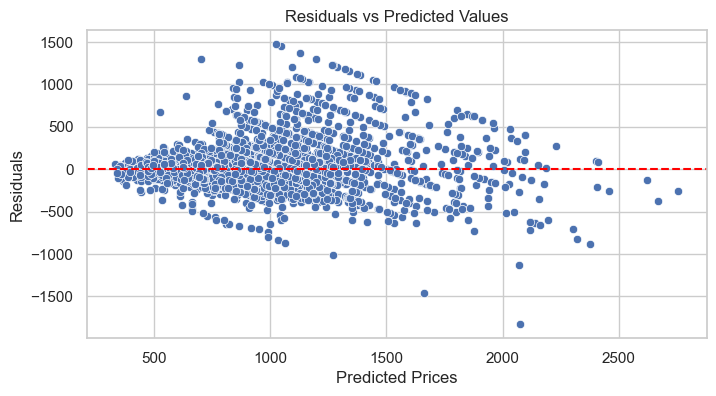

In [9]:
# Residuals (qalanlar) analizi
residuals = y_test - test_pred
plt.figure(figsize=(8, 4))
sns.scatterplot(x=test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals")
plt.show()
